## Examining the Relationship Between Economic Instability of Several Countries and BitCoin Market Capitalization

### Authors: Achal Srinivasan and Corrin Fosmire

### Section 1: Setting up Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import datetime as dt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

/home/infrared/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#using IMF API, acquire information for a particular country
def generate_data(country_abbr="US", metric="PXP_IX", resolution="M", start=2009, end=2017):
    data = requests.get("http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/"+resolution+"."+country_abbr+"."+metric+".?startPeriod="+str(start)+"&endPeriod="+str(end)).json()
    df = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    df = df.rename(index=str, columns={"@OBS_VALUE" : country_abbr+"."+metric, "@TIME_PERIOD" : "date"})
    return df

In [3]:
#loading economic health data for certain countries

countries = ["US", "KR", "JP", "RU"]
#United States, South, Korea, Japan, Russia

metrics = ["LE_IX", "PCPI_IX", "ENDE_XDC_USD_RATE"]
#consumer price index (should indicate inflation), exchange rate (in domestic currency), employment index

print(generate_data(country_abbr="KR",metric="LE_IX").head())

           KR.LE_IX     date
0  95.9151326814698  2009-01
1  95.4095737874995  2009-02
2  96.9304114479616  2009-03
3  98.6559692531425  2009-04
4  99.4640312877847  2009-05


In [4]:
def make_dataset(countries, metrics):
    #make first table, so then we can do joins on the rest
    empty = True
    full_data = None
    
    for country in countries:
        for metric in metrics:
            if empty:
                full_data = generate_data(country_abbr=country, metric=metric)
                empty = False
            else:
                metric_data = generate_data(country_abbr=country, metric=metric)
                full_data = full_data.merge(metric_data, on="date")
        time.sleep(5) #avoid throttling
                

    return full_data

In [5]:
financial_data = make_dataset(countries, metrics)

In [6]:
#deleting status variables we don't really care about
financial_data = financial_data[list(filter(lambda a: not a[0] == "@", list(financial_data.columns.values)))]

In [7]:
financial_data["date"] = financial_data["date"]+"-01"

In [8]:
#loading bitcoin data
btc_data = pd.read_csv("btc.csv")
btc_data = btc_data[btc_data["marketcap(USD)"] != np.nan]

#selecting columns of interest
mc_date = btc_data[["date","marketcap(USD)"]]

#converting to date time format
mc_date['date'] = pd.to_datetime(mc_date['date'])
mc_date = mc_date.dropna()

#years = [2013,2014,2015,2016]

#mc_date = mc_date[mc_date['date'].dt.year.isin(years) & mc_date['date'].dt.day.isin([1])]
mc_date['date'] = mc_date['date'].dt.strftime(date_format="%Y-%m-%d")
mc_date.head()

/home/infrared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,marketcap(USD)
1570,2013-04-28,1.500656e+09
1571,2013-04-29,1.491703e+09
1572,2013-04-30,1.598310e+09
1573,2013-05-01,1.543334e+09
1574,2013-05-02,1.292577e+09


In [9]:
combined = mc_date.merge(financial_data, on="date", how="left")
combined['date'] = pd.to_datetime(combined['date'])
combined = combined[combined['date'] < pd.to_datetime('2016-06-01')]

#convert data to numbers for interpolation & inference
for country in countries:
    for metric in metrics:
        combined[country+"."+metric] = pd.to_numeric(combined[country+"."+metric])

combined = combined.interpolate(method='linear').dropna()
combined.head()

,date,marketcap(USD),US.LE_IX,US.PCPI_IX,US.ENDE_XDC_USD_RATE,KR.LE_IX,KR.PCPI_IX,KR.ENDE_XDC_USD_RATE,JP.LE_IX,JP.PCPI_IX,JP.ENDE_XDC_USD_RATE,RU.LE_IX,RU.PCPI_IX,RU.ENDE_XDC_USD_RATE
3,2013-05-01,1.543334e+09,103.860155,106.828307,1.0,106.564325,107.468047,1129.700000,100.886501,99.7669,101.030000,102.734328,120.884098,31.589300
4,2013-05-02,1.292577e+09,103.869643,106.836577,1.0,106.574405,107.463831,1130.096774,100.883428,99.7669,100.936774,102.720462,120.900475,31.625419
5,2013-05-03,1.180430e+09,103.879130,106.844847,1.0,106.584486,107.459615,1130.493548,100.880355,99.7669,100.843548,102.706596,120.916853,31.661539
6,2013-05-04,1.090276e+09,103.888618,106.853116,1.0,106.594566,107.455399,1130.890323,100.877282,99.7669,100.750323,102.692730,120.933230,31.697658
7,2013-05-05,1.255228e+09,103.898105,106.861386,1.0,106.604646,107.451183,1131.287097,100.874209,99.7669,100.657097,102.678864,120.949608,31.733777


In [10]:
combined.tail()

,date,marketcap(USD),US.LE_IX,US.PCPI_IX,US.ENDE_XDC_USD_RATE,KR.LE_IX,KR.PCPI_IX,KR.ENDE_XDC_USD_RATE,JP.LE_IX,JP.PCPI_IX,JP.ENDE_XDC_USD_RATE,RU.LE_IX,RU.PCPI_IX,RU.ENDE_XDC_USD_RATE
2018,2018-11-06,1.116162e+11,110.454246,113.055621,1.0,110.697425,113.167035,1070.5,103.871497,104.843305,112.9,104.023881,169.578997,57.6002
2019,2018-11-07,1.123253e+11,110.454246,113.055621,1.0,110.697425,113.167035,1070.5,103.871497,104.843305,112.9,104.023881,169.578997,57.6002
2020,2018-11-08,1.132688e+11,110.454246,113.055621,1.0,110.697425,113.167035,1070.5,103.871497,104.843305,112.9,104.023881,169.578997,57.6002
2021,2018-11-09,1.118954e+11,110.454246,113.055621,1.0,110.697425,113.167035,1070.5,103.871497,104.843305,112.9,104.023881,169.578997,57.6002
2022,2018-11-10,1.109251e+11,110.454246,113.055621,1.0,110.697425,113.167035,1070.5,103.871497,104.843305,112.9,104.023881,169.578997,57.6002


### Section 2: Exploratory Data Analysis

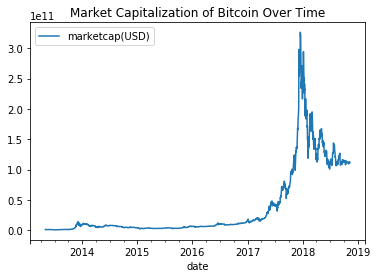

In [11]:
combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

#### We note that the market cap of BitCoin skyrocketed at the end of 2013, then gradually declined until 2015, where it rebounded again.

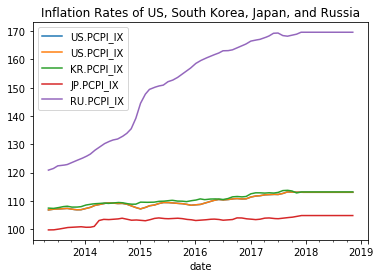

In [12]:
ax = combined.plot(x='date',y='US.PCPI_IX')
combined.plot(x='date',y='US.PCPI_IX', ax=ax)
combined.plot(x='date',y='KR.PCPI_IX', ax=ax)
combined.plot(x='date',y='JP.PCPI_IX', ax=ax)
combined.plot(x='date',y='RU.PCPI_IX', ax=ax, title="Inflation Rates of US, South Korea, Japan, and Russia")

#### Clearly, Venezuela's inflation rate is far, far greater than the other countries, and has been increasing more and more quickly with time.

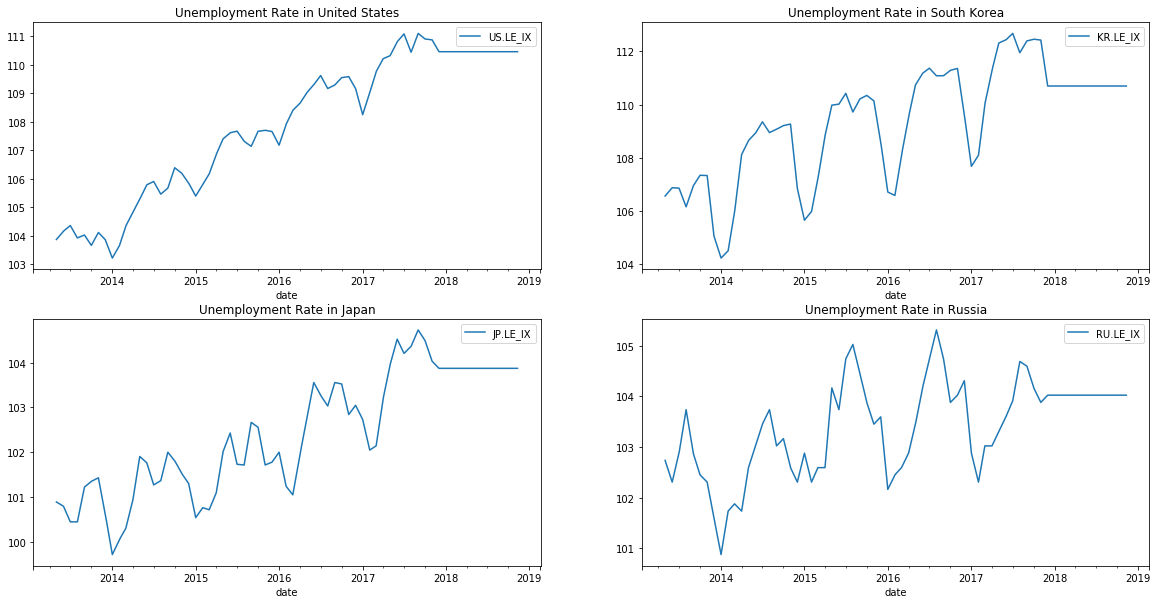

In [13]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.LE_IX', ax=ax1, title="Unemployment Rate in United States")
combined.plot(x='date',y='KR.LE_IX', ax=ax2, title="Unemployment Rate in South Korea")
combined.plot(x='date',y='JP.LE_IX', ax=ax3, title="Unemployment Rate in Japan")
combined.plot(x='date',y='RU.LE_IX', ax=ax4, title="Unemployment Rate in Russia")

#### Three of the countries had notably low unemployment rates in January 2014. Turkey seems to have a high degree of cyclical unemployment, and the United States and Turkey both have an upward trend. Venezuela and Uruguay have less of a trend but more volatility.

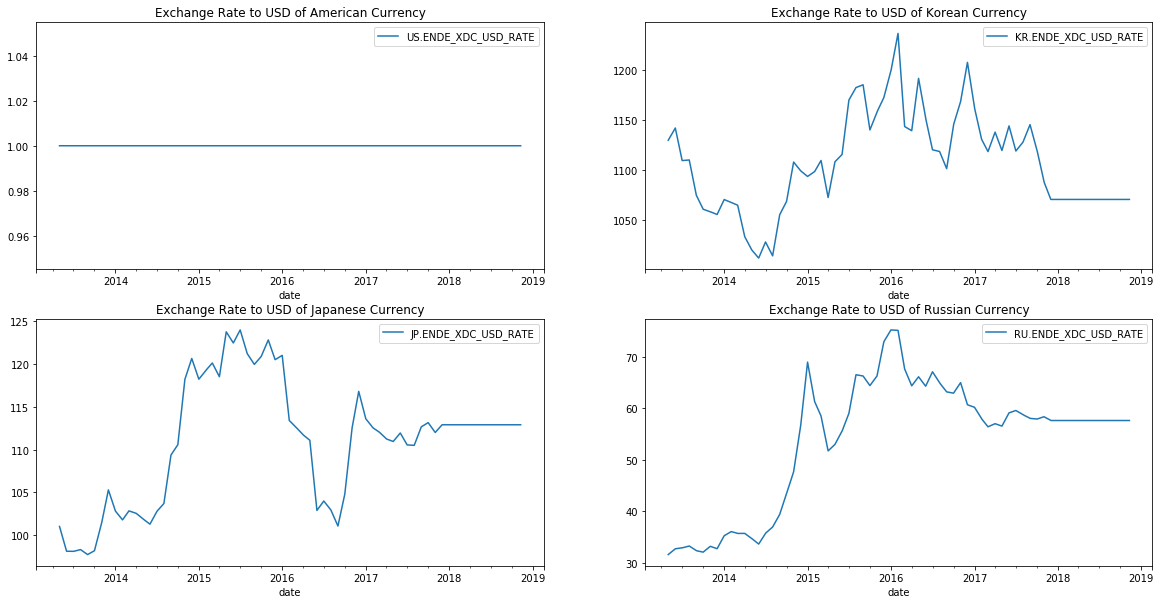

In [14]:
plt.rcParams['figure.figsize'] = (20,10)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

combined.plot(x='date',y='US.ENDE_XDC_USD_RATE', ax=ax1, title="Exchange Rate to USD of American Currency")
combined.plot(x='date',y='KR.ENDE_XDC_USD_RATE', ax=ax2, title="Exchange Rate to USD of Korean Currency")
combined.plot(x='date',y='JP.ENDE_XDC_USD_RATE', ax=ax3, title="Exchange Rate to USD of Japanese Currency")
combined.plot(x='date',y='RU.ENDE_XDC_USD_RATE', ax=ax4, title="Exchange Rate to USD of Russian Currency")

#### Clearly, the exchange rate in USD of USD is 1, which explains the line of the American currency. All three other currencies have been devalued relative to the USD steadily from 2013 to 2016, with the price of Venezuela markedly exploding in value after 2016, almost doubling in value.

### Section 3: Modeling

#### We will build models with and without exogenous regressors to predict BitCoin market cap, using both SARIMAX and Facebook Prophet models.

In [15]:
import fbprophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [16]:
#measures of interest: these seem to experimentally give the best results

countries = ["US", "KR", "JP"]#, "RU"]
#United States, South, Korea, Japan, Russia

metrics = ["LE_IX", "PCPI_IX"]#, "ENDE_XDC_USD_RATE"]
#consumer price index (should indicate inflation), exchange rate (in domestic currency), employment index

In [17]:
#test/train split
cryptoecon_train = combined[combined['date'] < pd.to_datetime('2016-01-01')]
cryptoecon_test = combined[(combined['date'] >= pd.to_datetime('2016-01-01')) & (combined['date'] < pd.to_datetime('2016-06-01'))]

In [18]:
#prophet dataframe preparation
prophet_df = pd.DataFrame(cryptoecon_train)
prophet_df['ds'] = prophet_df['date']
prophet_df['y'] = prophet_df['marketcap(USD)']

prophet_test = pd.DataFrame(cryptoecon_test)
prophet_test['ds'] = prophet_test['date']
prophet_test['y'] = prophet_test['marketcap(USD)']

In [19]:
#creating a model with no exogenous variables
no_exo_m = fbprophet.Prophet()#yearly_seasonality=False)
no_exo_m.fit(prophet_df)

#creating a model with all exogenous variables
all_exo_m = fbprophet.Prophet()#yearly_seasonality=False)

for country in countries:
    for metric in metrics:
        all_exo_m.add_regressor(country+"."+metric)
        
all_exo_m.fit(prophet_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
no_exo_preds = no_exo_m.predict(prophet_test)
all_exo_preds = all_exo_m.predict(prophet_test)

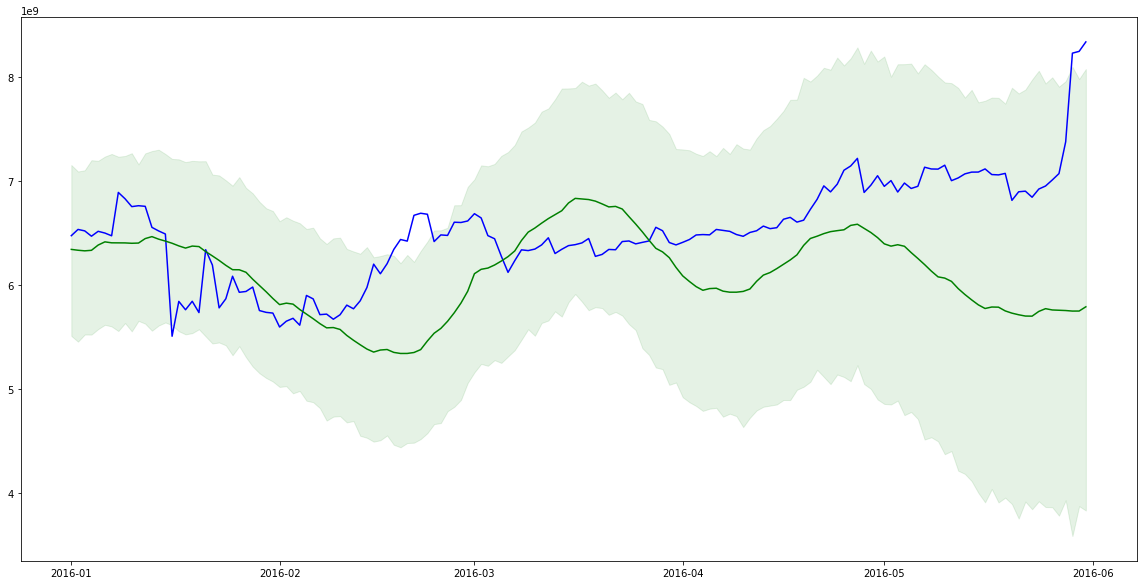

In [49]:
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")

plt.plot(prophet_test['ds'].values, all_exo_preds['yhat'].values, c="g")
plt.fill_between(prophet_test['ds'].values, all_exo_preds['yhat_lower'].values, all_exo_preds['yhat_upper'].values,alpha=0.1, color="g")

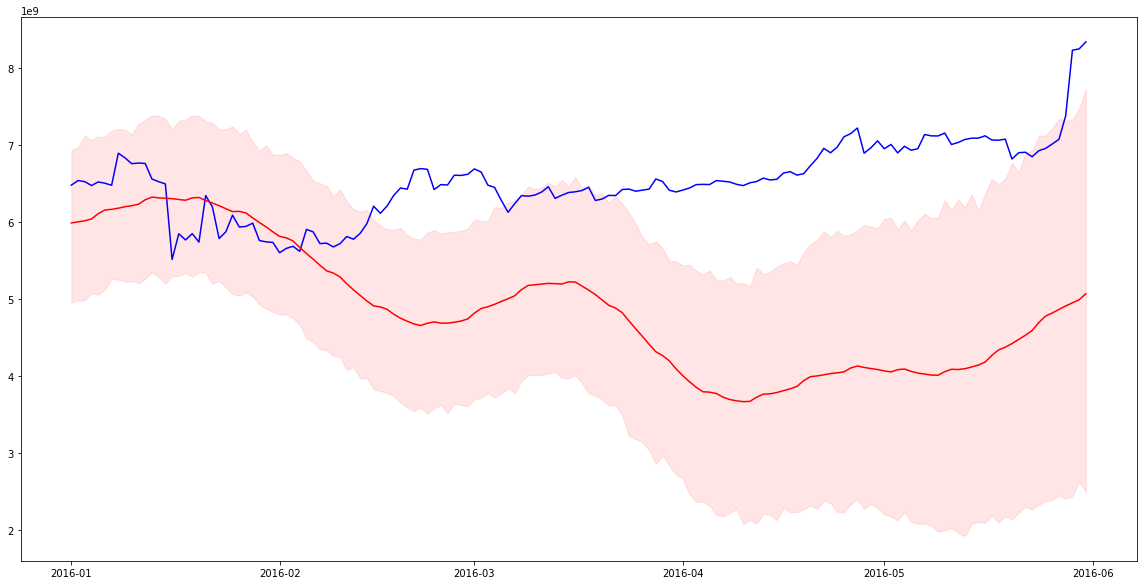

In [50]:
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")

plt.plot(prophet_test['ds'].values, no_exo_preds['yhat'].values, c="r")
plt.fill_between(prophet_test['ds'].values, no_exo_preds['yhat_lower'].values, no_exo_preds['yhat_upper'].values,alpha=0.1, color="r")

In [39]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
print("RMSE of no Exogenous Variables Model: \t" + str(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, no_exo_preds['yhat'].values))))
print("RMSE of all Exogenous Variables Model: \t" + str(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, all_exo_preds['yhat'].values))))

print(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, no_exo_preds['yhat'].values)) / np.std(prophet_test['marketcap(USD)'].values))
print(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, all_exo_preds['yhat'].values)) / np.std(prophet_test['marketcap(USD)'].values))

RMSE of no Exogenous Variables Model: 	2004137573.1770084
RMSE of all Exogenous Variables Model: 	730282540.2696323
4.085163316144708
1.4885821631502247


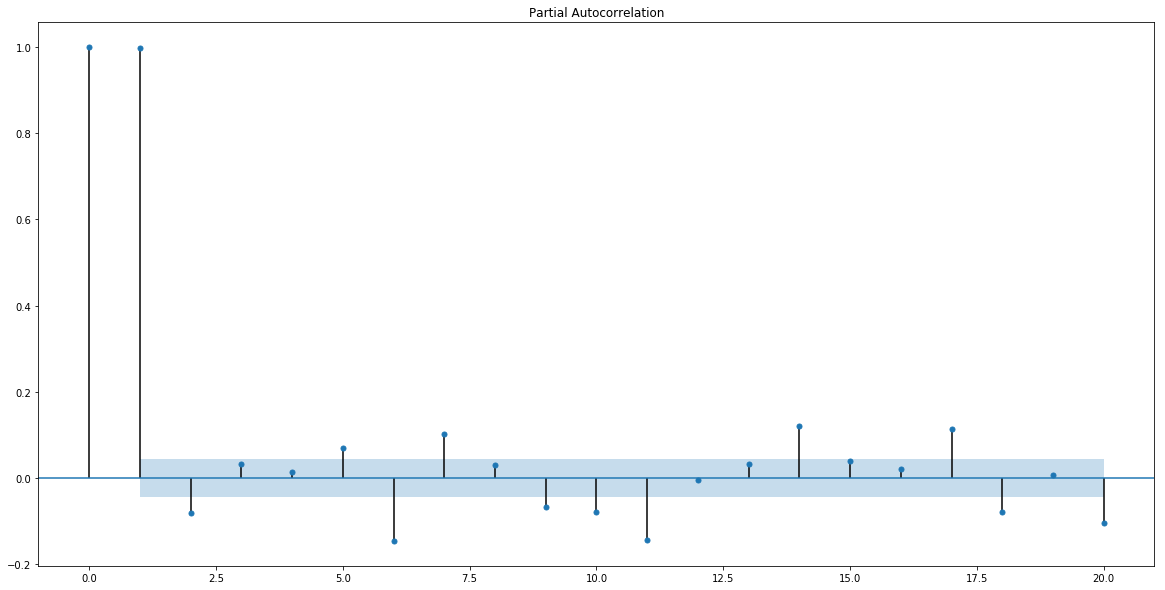

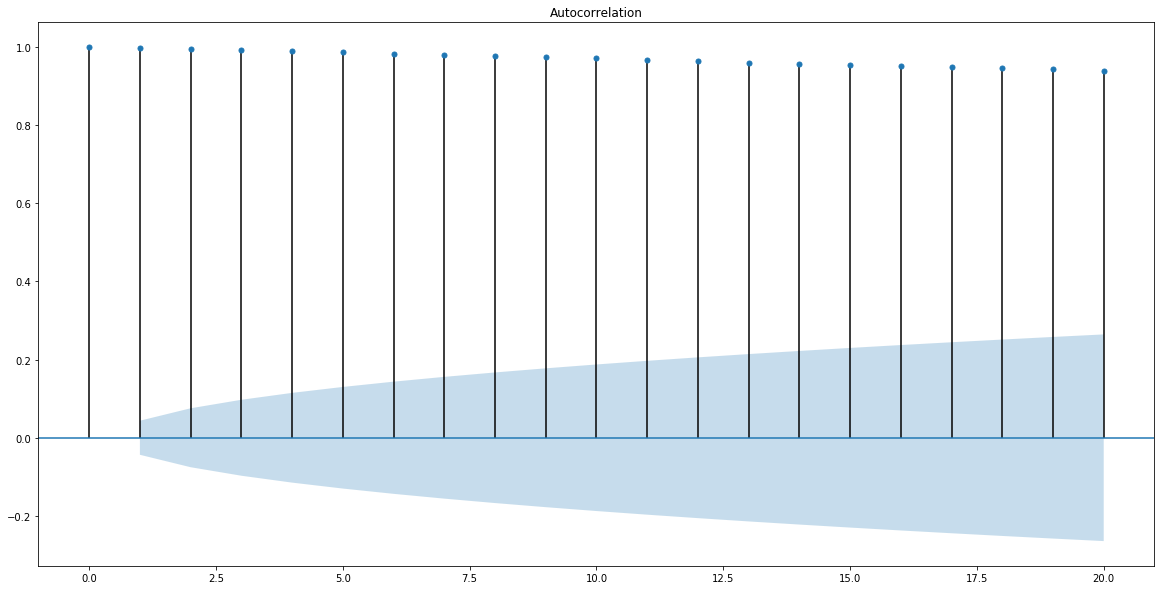

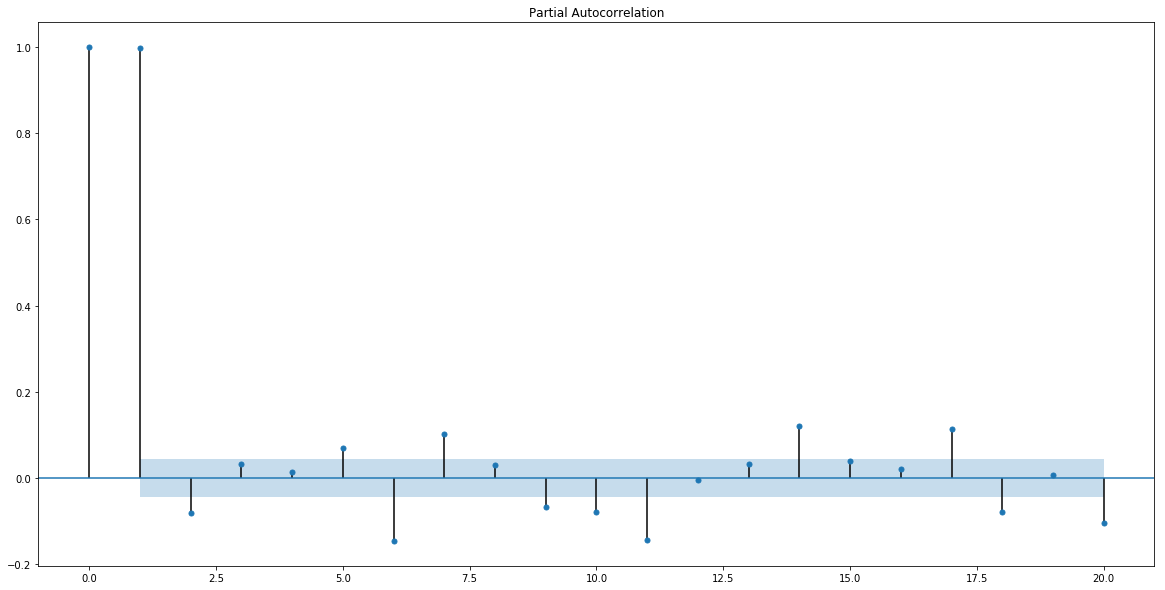

In [21]:
plot_acf(combined['marketcap(USD)'],lags=20)
plot_pacf(combined['marketcap(USD)'],lags=20)

#### Based on the above autocorrelation and partial autocorrelation plots, we estimate that the parameter p of the ARIMA model is about 2.

In [22]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [23]:
adf_test(cryptoecon_train['marketcap(USD)'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.928108
p-value                          0.318956
#Lags Used                      21.000000
Number of Observations Used    953.000000
Critical Value (1%)             -3.437230
Critical Value (5%)             -2.864578
Critical Value (10%)            -2.568387
dtype: float64


In [24]:
adf_test(cryptoecon_train['marketcap(USD)'].diff(2).dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.413604e+00
p-value                        7.028990e-11
#Lags Used                     2.000000e+01
Number of Observations Used    9.520000e+02
Critical Value (1%)           -3.437238e+00
Critical Value (5%)           -2.864581e+00
Critical Value (10%)          -2.568389e+00
dtype: float64


In [25]:
no_exog_sari = SARIMAX(cryptoecon_train['marketcap(USD)'],order=(2,2,0))
no_exog_sarim = no_exog_sari.fit()

#creating exogenous variables: just drop date and marketcap from training data and convert to array
exog = cryptoecon_train.drop(['marketcap(USD)','date','ds','y'], axis=1).values.astype(float)

all_exog_sari = SARIMAX(cryptoecon_train['marketcap(USD)'], exog, order=(2,2,0))
all_exog_sarim = all_exog_sari.fit()

/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Co

/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/infrared/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


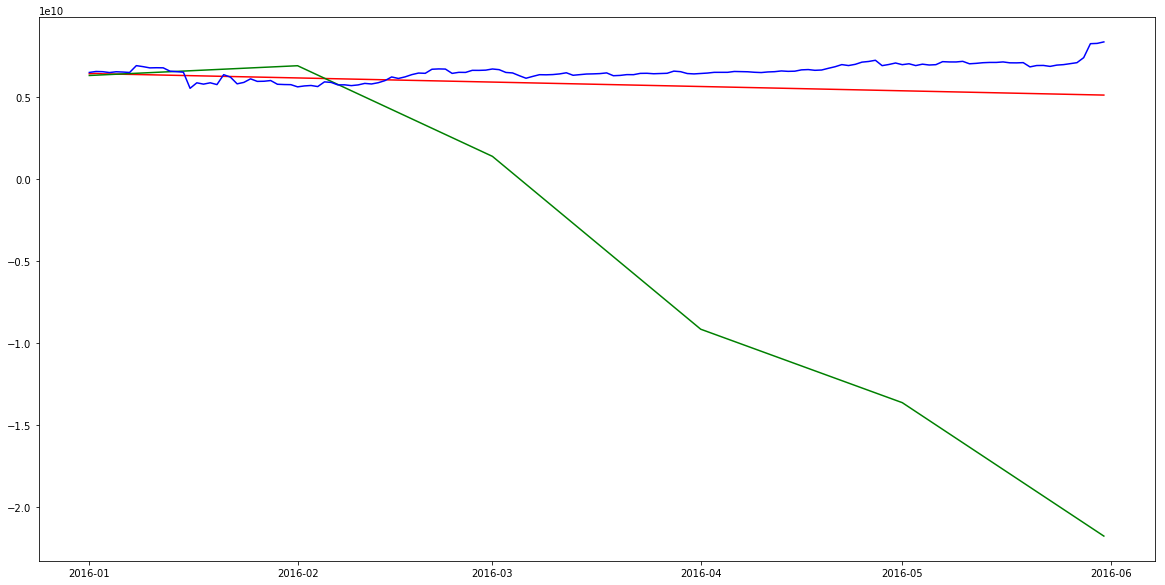

In [26]:
exog = cryptoecon_test.drop(['marketcap(USD)','date','ds','y'], axis=1).values.astype(float)

sarim_no_predix = no_exog_sarim.get_forecast(152).predicted_mean
sarim_all_predix = all_exog_sarim.get_forecast(152, exog=exog).predicted_mean

cryptoecon_test['date'].values

plt.plot(cryptoecon_test['date'].values,sarim_no_predix, c='r')
plt.plot(cryptoecon_test['date'].values,sarim_all_predix, c='g')
plt.plot(cryptoecon_test['date'].values,cryptoecon_test['marketcap(USD)'].values, c='b')

### Section 4: Data Visualization